In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [285]:
import os
import numpy as np
import pandas as pd 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import matplotlib.pyplot as plt

In [115]:
import torch, torch.nn.functional as F
from torch import ByteTensor, DoubleTensor, FloatTensor, HalfTensor, LongTensor, ShortTensor, Tensor
from torch import nn, optim, as_tensor
from torch.utils.data import BatchSampler, DataLoader, Dataset, Sampler, TensorDataset
from torch.nn.utils import weight_norm

from collections.abc import Iterable
from tqdm import tqdm_notebook as tqdm

## Data

In [4]:
ref_train_x = pd.read_csv('data/train_features.csv')
ref_train_y = pd.read_csv('data/train_targets_scored.csv')
# train_y2 = pd.read_csv('data/train_targets_nonscored.csv')

ref_test_x = pd.read_csv('data/test_features.csv')
smplsub = pd.read_csv('data/sample_submission.csv')

In [5]:
def get_label_stratified_val_idxs(df, val_size=0.1, rnd=0):
    
    arr = df.to_numpy()

    X = arr[:,0]
    y = arr[:,1:] # this works irrespective of whether labels are space- or comma-separated
    
    ### sklearn.model_selection.StratifiedKFold
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=rnd)
    
    for train_index, val_index in sss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index

    data_report(df, trn_idxs, val_idxs)
    return trn_idxs, val_idxs

def finalize_df(df, targets, as_multi=True): 
    # Select and fuse labels into target column (space separated)
    df_slct = df[[df.columns[0]] + targets]
    if as_multi:
        df_out = np.array([[df_slct.values[i][0], ' '.join(str(x) for x in df_slct.values[i][1:])] for i in range(len(df_slct))])
        return pd.DataFrame(df_out, columns = ["ID", "Target"])
    else: 
        df_out = np.array(df_slct)
        if len(targets) == 1: return pd.DataFrame(df_out, columns = ["ID", 'Target'])
        else: return pd.DataFrame(df_out, columns = ["ID"] + targets)

def data_report(df, trn_idxs, val_idxs, test_csv=None):
    trnval = df
    if len(trnval.columns) != 2:
        print(f"Multilabel csv with comma-separated labels detected!\n")
        trnval = finalize_df(trnval, targets=list(trnval.columns)[1:])
    print(f"""Train label-distribution:\n"""
          f"""{trnval['Target'][trn_idxs].value_counts()}\n"""
          f"""Total: {len(trn_idxs)}\n""")
    print(f"""Val label-distribution:\n"""
          f"""{trnval['Target'][val_idxs].value_counts()}\n"""
          f"""Total: {len(val_idxs)}""")

In [6]:
trn_idxs, val_idxs = get_label_stratified_val_idxs(ref_train_x.iloc[:,:3], val_size=0.1, rnd=0)

Multilabel csv with comma-separated labels detected!

Train label-distribution:
trt_cp 48         6842
trt_cp 72         6462
trt_cp 24         6449
ctl_vehicle 48     583
ctl_vehicle 72     551
ctl_vehicle 24     545
Name: Target, dtype: int64
Total: 21432

Val label-distribution:
trt_cp 48         760
trt_cp 72         718
trt_cp 24         717
ctl_vehicle 48     65
ctl_vehicle 24     61
ctl_vehicle 72     61
Name: Target, dtype: int64
Total: 2382


In [7]:
# # convert_to_numeric
# ref_train_x['cp_type'] = ref_train_x['cp_type'].apply(lambda x : 0 if x == "trt_cp" else 1 )
# ref_train_x['cp_dose'] = ref_train_x['cp_dose'].apply(lambda x : 1 if x == "D1" else 2 )

# ref_test_x['cp_type'] = ref_test_x['cp_type'].apply(lambda x : 0 if x == "trt_cp" else 1 )
# ref_test_x['cp_dose'] = ref_test_x['cp_dose'].apply(lambda x : 1 if x == "D1" else 2 )

# # split train/val
# _X_train, _Y_train = ref_train_x.loc[trn_idxs], ref_train_y.loc[trn_idxs]
# _X_valid, _Y_valid = ref_train_x.loc[val_idxs], ref_train_y.loc[val_idxs]

# # select features / format dfs:
# x_fts = list(_X_train.columns[1:])
# y_fts = list(_Y_train.columns[1:])
# X_train, X_valid, X_test = _X_train[x_fts], _X_valid[x_fts], ref_test_x[x_fts]
# Y_train, Y_valid = _Y_train[y_fts], _Y_valid[y_fts]

In [8]:
def onehot_col(df, col):
    enc = pd.get_dummies(df[col])
    enc.columns = [f"{col}_{n}" for n in enc.columns]
    df = df.drop(col, axis=1)
    df = df.join(enc)
    return df

def prep_data(df, cols, func=onehot_col):
    for i in cols: df = func(df, i)
    return df

In [9]:
_ref_train_x = prep_data(ref_train_x, cols=['cp_type', 'cp_time', 'cp_dose'])
_ref_test_x = prep_data(ref_test_x, cols=['cp_type', 'cp_time', 'cp_dose'])

x_fts = _ref_train_x.columns[1:]
y_fts = ref_train_y.columns[1:]

trnval_df_rdy = pd.merge(_ref_train_x, ref_train_y, on='sig_id')
test_df_rdy = _ref_test_x

In [10]:
test_df_rdy.head()

,sig_id,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-97,c-98,c-99,cp_type_ctl_vehicle,cp_type_trt_cp,cp_time_24,cp_time_48,cp_time_72,cp_dose_D1,cp_dose_D2
0,id_0004d9e33,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,0.2221,-0.3260,...,-0.0502,0.1510,-0.7750,0,1,1,0,0,1,0
1,id_001897cda,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,0.4022,-0.3528,...,-0.4764,-1.3810,-0.7300,0,1,0,0,1,1,0
2,id_002429b5b,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,-0.3390,-0.3206,0.6944,...,1.0160,0.4924,-0.1942,1,0,1,0,0,1,0
3,id_00276f245,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,-0.1799,0.9365,...,-0.1305,0.5645,-0.5809,0,1,1,0,0,0,1
4,id_0027f1083,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,0.6365,0.2611,...,-0.5313,0.9931,1.8380,0,1,0,1,0,1,0


## Dataloader 

In [86]:
class MOA_data:
    def __init__(self, x_fts, y_fts, bs=512):
        self.x_fts, self.y_fts, self.bs = x_fts, y_fts, bs
    
    def embed(df):
        return df

    def create(self, df, val_idxs, test=None): 
        train = df.drop(val_idxs)
        valid = df.loc[val_idxs]
        for ID in val['sig_id']: assert ID not in list(trn['sig_id']) 
        self.train_ds = MOA_ds(train, self.x_fts, self.y_fts)
        self.valid_ds = MOA_ds(valid, self.x_fts, self.y_fts)
        self.train_dl = DataLoader(self.train_ds, batch_size=self.bs, shuffle=True)
        self.valid_dl = DataLoader(self.valid_ds, batch_size=self.bs, shuffle=False)
        
        if test is not None:
            self.test_ds = MOA_ds(test, self.x_fts, y_fts, test=True)
            self.test_dl = DataLoader(self.test_ds, batch_size=self.bs, shuffle=False)

class MOA_ds(Dataset):
    def __init__(self, df, x_fts, y_fts, test=False):
        if test: self.x, self.y = df[x_fts].to_numpy(), np.zeros((df.shape[0], len(y_fts)))
        else: self.x, self.y = df[x_fts].to_numpy(), df[y_fts].to_numpy()
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return [torch.tensor(self.x[idx, :], dtype=torch.float),
                torch.tensor(self.y[idx, :], dtype=torch.float)]

In [88]:
data = MOA_data(x_fts, y_fts)
data.create(trnval_df_rdy, val_idxs, test=test_df_rdy)

## Model 

In [92]:
def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p=None, q=None):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    #Rank 0 tensors in PyTorch are Iterable but don't have a length.
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

def emb_sz_rule(n_cat:int)->int: return min(600, round(1.6 * n_cat**0.56))

def def_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

def get_emb_szs(self, sz_dict=None):
    "Return the default embedding sizes suitable for this data or takes the ones in `sz_dict`."
    return [def_emb_sz(self.classes, n, sz_dict) for n in self.cat_names]

def embedding(ni,nf):
    "Create an embedding layer."
    emb = nn.Embedding(ni, nf)
    with torch.no_grad(): trunc_normal_(emb.weight, std=0.01)
    return emb

In [141]:
def bn_drop_lin(n_in, n_out, bn=True, p=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

class SimpleNet(nn.Module):
    def __init__(self, in_fts, layers, out_sz, ps=None, use_bn=True, bn_final=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        sizes = [in_fts] + layers + [out_sz]
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        layers = []
        
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.layers(x)
        return x

In [142]:
ni = data.train_ds.x.shape[1]
layers = [512, 512, 256, 128]
out_sz = 206

m = SimpleNet(ni, layers, out_sz, ps=0.3)
m

SimpleNet(
  (layers): Sequential(
    (0): Linear(in_features=879, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): ReLU(inplace)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU(inplace)
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.3)
    (16): Linear(in_features=128, out_features=206, bias=True)
  )
)

## Train

In [331]:
def to_np(x): 
    return x.data.cpu().numpy()

def loss_batch(model, x, y, loss_func, opt=None): 
    out = model(x)
    if not loss_func: return to_np(out), to_np(y)
    loss = loss_func(out, y)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.detach().cpu()    
    
def validate(model, dl, loss_fn=None, average=True):
    model.eval()
    with torch.no_grad():
        val_losses,nums = [],[]
#         for xb,yb in tqdm(dl, total=len(dl), unit='batches'):
        for xb,yb in dl:
            val_loss = loss_batch(model, xb, yb, loss_fn)
            val_losses.append(val_loss)
            nums.append(xb.shape[0])
        nums = np.array(nums, dtype=np.float32)
        if average: return (to_np(torch.stack(val_losses)) * nums).sum() / nums.sum()
        else:       return val_losses
        
def fit(model, data, loss_fn, opt, epochs, average=True):
    for e in tqdm(range(epochs), total=epochs, unit='epochs'):
        model.train()
        train_losses, nums = [], []
#         for xb,yb in tqdm(data.train_dl, total=len(data.train_dl), unit='batches'):
        for xb,yb in data.train_dl:
            loss = loss_batch(model, xb, yb, loss_fn, opt)
            train_losses.append(loss)
            nums.append(xb.shape[0])
        nums = np.array(nums, dtype=np.float32)
        train_loss = (np.stack(train_losses) * nums).sum() / nums.sum()
        valid_loss = validate(model, data.valid_dl, loss_fn, average=True)
        print(f"Epoch {e} -- train_loss: {train_loss}, valid_loss: {valid_loss}")
    print('done!')

class learner():
    def __init__(self, model, data, loss_fn, opt=optim.Adam):
        self.m, self.data, self.loss_fn = model, data, loss_fn
        self.opt = opt
    
    def fit(self, epochs, lr=1e-3, wd=1e-5):
        opt = self.opt(self.m.parameters(), lr=lr)
        fit(self.m, self.data, self.loss_fn, opt, epochs)  
        
    def predict(self, dl):
        return validate(self.m, dl, loss_fn=None, average=False)

In [332]:
ni = data.train_ds.x.shape[1]
layers = [512, 512, 256, 128]
out_sz = 206

m = SimpleNet(ni, layers, out_sz, ps=0.4)

In [333]:
loss_func = nn.BCEWithLogitsLoss()
learn = learner(m, data, loss_func)

In [334]:
learn.fit(20, lr=1e-2, wd=None)

Epoch 0 -- train_loss: 0.20166140794754028, valid_loss: 0.022816205397248268
Epoch 1 -- train_loss: 0.021588550880551338, valid_loss: 0.01898844540119171
Epoch 2 -- train_loss: 0.0195272509008646, valid_loss: 0.018195243552327156
Epoch 3 -- train_loss: 0.01900353468954563, valid_loss: 0.017815884202718735
Epoch 4 -- train_loss: 0.01858995296061039, valid_loss: 0.01741376519203186
Epoch 5 -- train_loss: 0.018144868314266205, valid_loss: 0.016912614926695824
Epoch 6 -- train_loss: 0.017706310376524925, valid_loss: 0.016627350822091103
Epoch 7 -- train_loss: 0.01733754761517048, valid_loss: 0.0163926612585783
Epoch 8 -- train_loss: 0.017133638262748718, valid_loss: 0.01624292880296707
Epoch 9 -- train_loss: 0.016882838681340218, valid_loss: 0.016110436990857124
Epoch 10 -- train_loss: 0.01664646714925766, valid_loss: 0.015941431745886803
Epoch 11 -- train_loss: 0.01645747572183609, valid_loss: 0.015824882313609123
Epoch 12 -- train_loss: 0.01623309962451458, valid_loss: 0.0157441440969705

In [335]:
def unpack(res_list):
    preds = np.vstack([p[0] for p in res_list])
    preds = nn.Sigmoid()(torch.tensor(preds))
    y = np.vstack([p[1] for p in res_list])
    return [preds, y]

def eval_model(learn_obj):
    res = {'train preds': unpack(learn_obj.predict(learn_obj.data.train_dl)), 
           'valid preds': unpack(learn_obj.predict(learn_obj.data.valid_dl)), 
           'train baseline': [learn_obj.data.train_ds.y, np.zeros(learn_obj.data.train_ds.y.shape)],
           'valid baseline': [learn_obj.data.valid_ds.y, np.zeros(learn_obj.data.valid_ds.y.shape)]}
        
    return res['train preds'], res['valid preds']

In [336]:
train_res, valid_res = eval_model(learn)

In [337]:
train_pred = to_np(train_res[0])
train_y = train_res[1]

valid_pred = to_np(valid_res[0])
valid_y = valid_res[1]

(array([4399802.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   15190.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

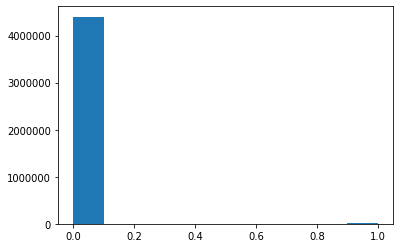

In [338]:
plt.hist(train_y.ravel())

In [339]:
print(metrics.log_loss(train_y, train_pred))
print(metrics.log_loss(train_y, np.zeros(train_y.shape)))
print('\n')
print(metrics.log_loss(valid_y, valid_pred))
print(metrics.log_loss(valid_y, np.zeros(valid_y.shape)))

2.1842602658996806
3.7761496362408424


2.4985078247321804
3.699541218798475
